In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
train_data = kgs.load_all_train_data()
data = np.stack([d.spectrum for d in train_data]).T
wavelengths = kgs.wavelengths
#data = data[:,1:].T
#data.shape, wavelengths.shape

local


Text(0, 0.5, 'Transit depth')

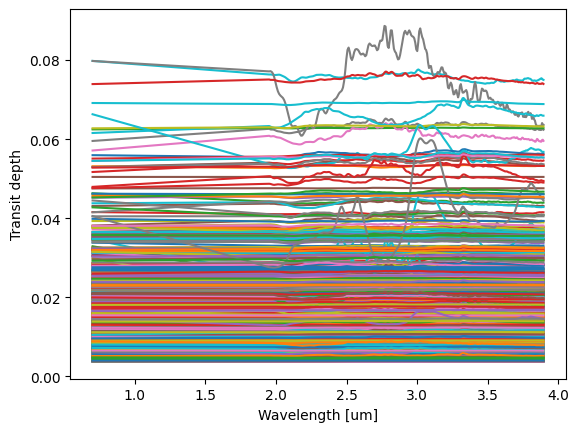

In [2]:
plt.figure()
plt.plot(wavelengths, data);
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth')

Text(0, 0.5, 'Transit depth (mean removed)')

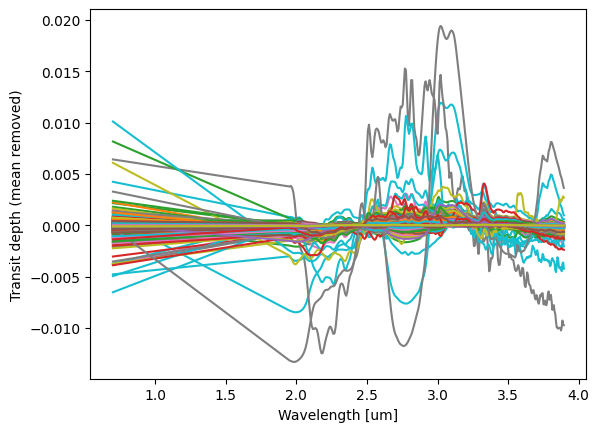

In [3]:
plt.figure()
plt.plot(wavelengths, data-np.mean(data,0));
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed)')

1.0


Text(0, 0.5, 'Transit depth (mean removed, normalized)')

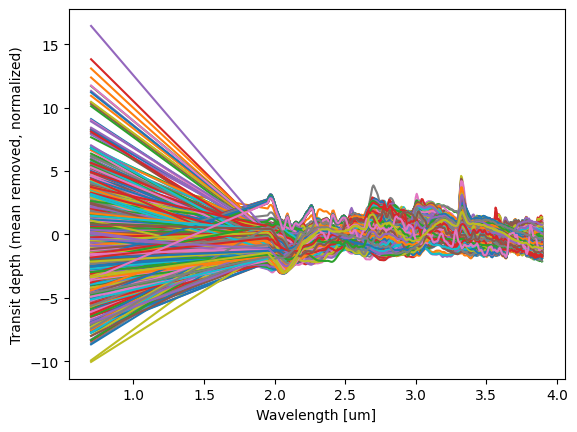

In [4]:
high_std = np.std(data,0)>0
print(np.sum(high_std)/len(high_std))
this_data = data[:,high_std]
data_norm = (this_data-np.mean(this_data,0))/np.std(this_data,0)
plt.figure()
plt.plot(wavelengths, data_norm);
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed, normalized)')

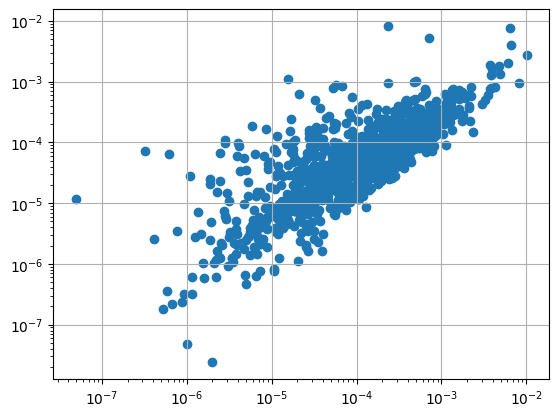

In [5]:
plt.figure()
data_mean_corrected = data-np.mean(data,0)
plt.scatter(np.abs(data_mean_corrected[0,:]), np.std(data_mean_corrected[1:,:],0))
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.grid(True)

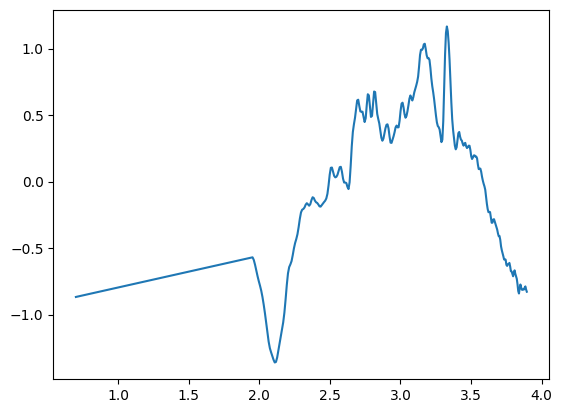

In [6]:
plt.figure()
plt.plot(wavelengths, np.mean(data_norm,1))

Text(0, 0.5, 'Std of transit depth')

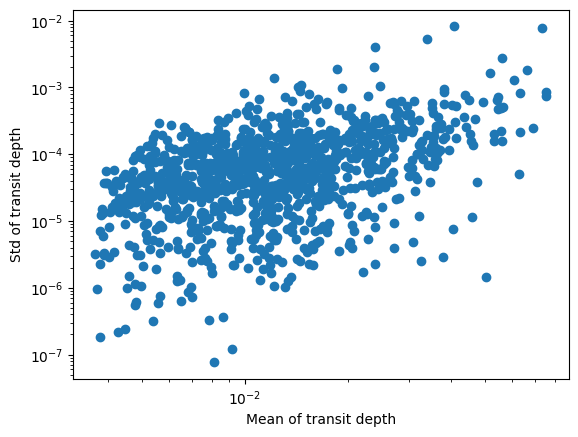

In [7]:
plt.figure()
plt.scatter(np.mean(data,0), np.std(data,0))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean of transit depth')
plt.ylabel('Std of transit depth')

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Treat columns of `data` as samples (like your original `.T` did)
# X shape: (n_samples, n_features)
X = (data-np.mean(data,0)).T  # NO CENTERING
#X = ((this_data-np.mean(this_data,0))/np.std(this_data,0)).T

for iii in range(20):
    # SVD: X = U @ np.diag(S) @ Vh
    U, S, Vh = np.linalg.svd(X, full_matrices=False)

    # Principal directions in feature space (rows = PCs)
    components = Vh                              # shape: (n_components, n_features)

    # Weights / scores of each sample on each PC
    weights = U * S                              # shape: (n_samples, n_components)

    # Explained variance (uncentered): eigenvalues of X^T X scaled like sklearn
    n_samples = X.shape[0]
    den = max(n_samples - 1, 1)                  # avoid /0 if there's only 1 sample
    explained_variance = (S**2) / den            # per-component variance (like sklearn's PCA.explained_variance_)
    explained_variance_ratio = (S**2) / np.sum(S**2)

    # Your plots
    #plt.figure()
    #plt.plot(wavelengths, components[:5, :].T)   # first 5 PCs as spectra vs wavelength

   # plt.figure()
    #plt.plot(1 - np.cumsum(explained_variance_ratio)[:20])  # leftover variance (like your original)
   # plt.plot(explained_variance_ratio[:20])
   # plt.pause(0.001)
    #(1 - np.cumsum(explained_variance_ratio)[:20])[0]
    #kgs.rms(X),kgs.rms(X-weights@components)

    # Rescale weights such that nobody gets more than 10% of the signal
    for ii in range(len(wavelengths)):
        if explained_variance_ratio[ii]>0.2:
            weights[:,ii] *= (0.2/explained_variance_ratio[ii])**2

    X = weights@components
data_rescaled = X.T

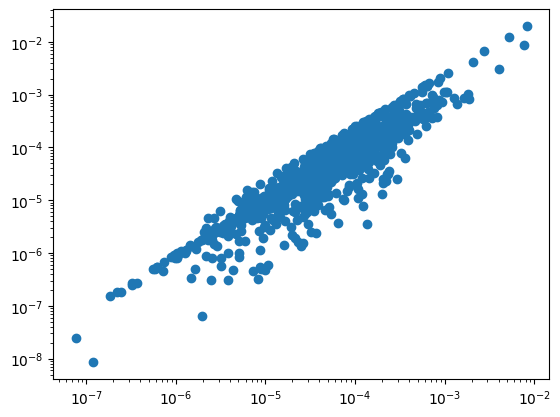

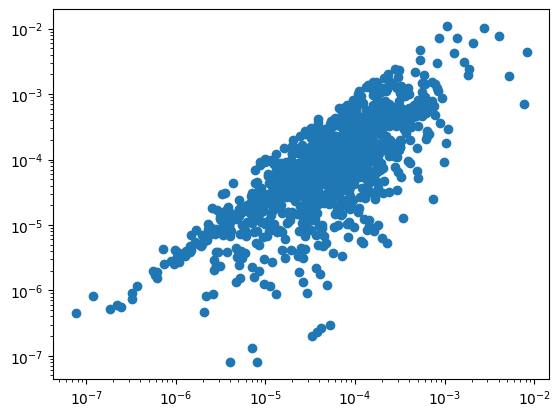

In [20]:
for ii in range(2):
    plt.figure()
    plt.scatter(np.std(data,0), np.abs(weights[:,ii]))
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')

Text(0, 0.5, 'Transit depth (mean removed, normalized)')

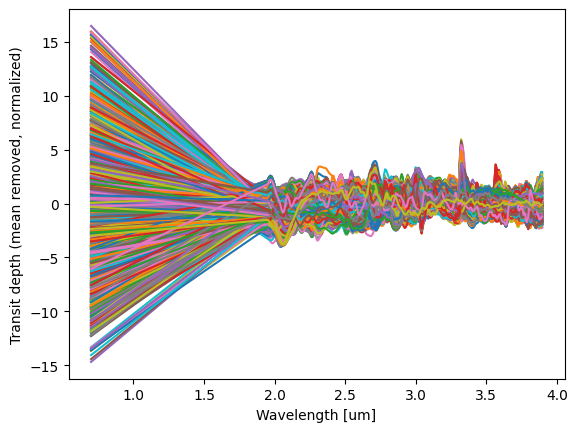

In [9]:
this_data = data_rescaled
data_norm = (this_data-np.mean(this_data,0))/np.std(this_data,0)
plt.figure()
plt.plot(wavelengths, data_norm);
plt.xlabel('Wavelength [um]')
plt.ylabel('Transit depth (mean removed, normalized)')

In [10]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import UnivariateSpline
from numpy.linalg import eigh
import scipy

def empirical_cov(Y):
    # Y: (N,M), rows = sample paths, cols = points
    Yc = Y - Y.mean(axis=0, keepdims=True)
    return (Yc.T @ Yc) / (Y.shape[0] - 1)

def bin_by_distance(x, K, nbins=50, min_per_bin=20):
    x = np.asarray(x).ravel()
    D = squareform(pdist(x[:,None], 'euclidean'))  # (M,M)
    r = D[np.triu_indices_from(D)]
    v = K[np.triu_indices_from(K)]
    # bin edges from 0 to max distance
    edges = np.linspace(0, r.max() + 1e-12, nbins+1)
    centers, means = [], []
    for a,b in zip(edges[:-1], edges[1:]):
        mask = (r >= a) & (r < b)
        if mask.sum() >= min_per_bin:
            centers.append(0.5*(a+b))
            means.append(v[mask].mean())
    return np.array(centers), np.array(means)

def smooth_kernel(r, k_r, s=None):
    # s: smoothing factor (None lets spline choose ~ good default)
    # Enforce evenness & k'(0)=0 by mirroring
    r_full = np.concatenate([-r[::-1], r])
    k_full = np.concatenate([k_r[::-1], k_r])
    #spl = UnivariateSpline(r_full, k_full, s=s)
    spl = scipy.interpolate.interp1d(r_full, k_full, fill_value='extrapolate')
    plt.figure()
    plt.plot(r_full,k_full)
    plt.title('Input to spline')
    def kfun(h):
        h = np.abs(np.asarray(h))
        return spl(h)
    return kfun

def nearest_psd(A, eps=1e-12):
    # Higham-like eigenvalue clipping
    w, V = eigh((A + A.T)/2)
    w = np.clip(w, eps, None)
    return (V * w) @ V.T

# Example parametric kernels
def k_rbf(r, amp, ell): return amp**2 * np.exp(-0.5*(r/ell)**2)
def k_matern32(r, amp, ell): 
    z = np.sqrt(3)*r/ell
    return amp**2 * (1+z)*np.exp(-z)

def fit_parametric_from_cov(x, K_emp, family='matern32', nugget=True):
    from scipy.optimize import minimize

    D = squareform(pdist(x[:,None], 'euclidean'))
    def K_theta(theta):
        amp = np.exp(theta[0]); ell = np.exp(theta[1])
        if family == 'rbf':
            K = k_rbf(D, amp, ell)
        else:
            K = k_matern32(D, amp, ell)
        if nugget:
            sn2 = np.exp(theta[2])
            K = K + sn2*np.eye(len(x))
        return K

    # init guesses from data scale
    amp0 = np.sqrt(np.median(np.diag(K_emp)))
    ell0 = (x.max()-x.min())/5
    th0 = [np.log(max(amp0,1e-6)), np.log(max(ell0,1e-6))]
    if nugget:
        sn20 = max(1e-6, 0.01*np.median(np.diag(K_emp)))
        th0.append(np.log(sn20))

    def obj(theta):
        Kt = K_theta(theta)
        R = K_emp - Kt
        return np.sum(R*R)  # Frobenius norm squared

    res = minimize(obj, np.array(th0), method='L-BFGS-B')
    return res

def estimate_kernel(x, Y, nbins=50, min_per_bin=20, smooth_s=None, enforce_psd=True):
    # Empirical covariance
    K_emp = empirical_cov(Y)
    plt.figure()
    plt.imshow(K_emp)
    plt.colorbar()

    # Nonparametric kernel estimate (bin + smooth)
    r, k_r = bin_by_distance(x, K_emp, nbins=nbins, min_per_bin=min_per_bin)
    plt.figure()
    plt.plot(r,k_r)
    kfun = smooth_kernel(r, k_r, s=smooth_s)
    plt.figure()
    plt.plot(r,kfun(r))

    # Build covariance from kfun on grid
    D = squareform(pdist(np.asarray(x)[:,None], 'euclidean'))
    K_np = kfun(D)

    if enforce_psd:
        K_np = nearest_psd(K_np)

    return K_np, kfun, K_emp

Fitted params (log): [ -9.19037579  -0.94506305 -13.81551056]


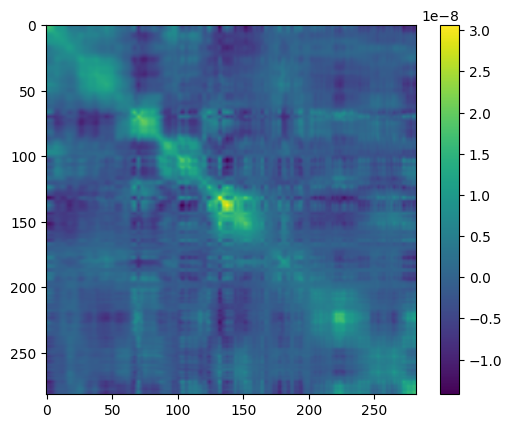

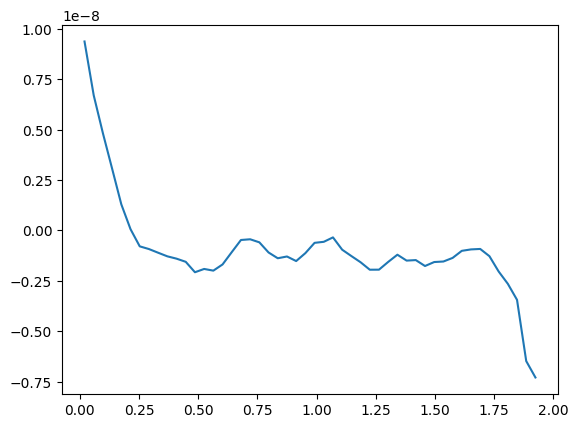

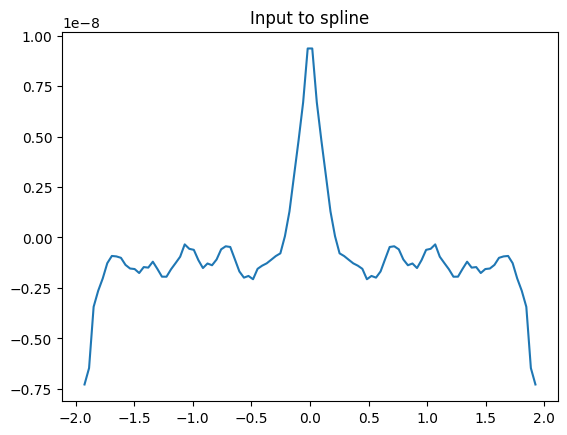

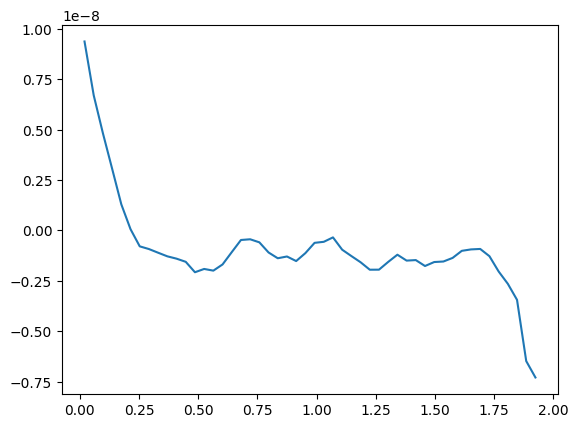

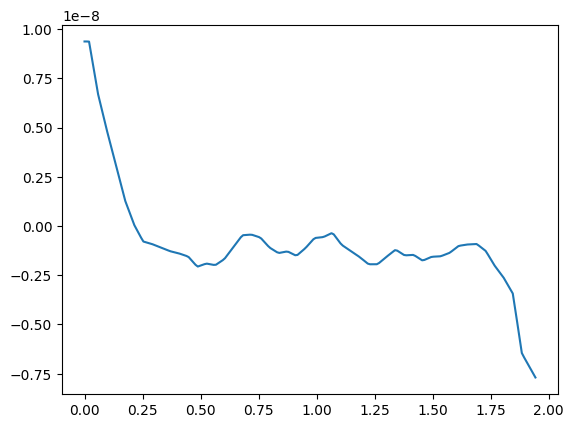

In [11]:
#from sklearn.decomposition import PCA import numpy as np
# x=kgs.wavelengths[1:]
# dat = data_norm
# Y=(dat-np.mean(dat,0)).T
# Y=Y-np.mean(Y,1)[:,None]

# pca = PCA(n_components=5)
# pca.fit(Y.T)
# components = pca.components_          # Principal directions (eigenvectors)
# explained_variance = 1-np.cumsum(pca.explained_variance_ratio_)  # Variance explained by each PC

# plt.figure()
# plt.plot(explained_variance)

# ii=2
# scores = pca.transform(Y.T)[:, :ii]             # (n_samples, ii)
# recon = scores @ pca.components_[:ii, :]      # (n_samples, 64)
# recon += pca.mean_    

x= wavelengths[1:]
Y = data_rescaled[1:,:].T

# x: shape (M,), Y: shape (N,M)
K_np, kfun, K_emp = estimate_kernel(x, Y)

# Evaluate kernel at any lag r>=0:
r_test = np.linspace(0, (x.max()-x.min()), 200)
k_vals = kfun(r_test)

plt.figure()
plt.plot(r_test,k_vals)

# # (Optional) fit a parametric kernel to the empirical covariance:
res = fit_parametric_from_cov(x, K_emp, family='matern32', nugget=True)
print("Fitted params (log):", res.x)

In [47]:
import ariel_gp
kgs.debugging_mode = 1
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = False
model.train(train_data)
model.infer(train_data[0:1]);
mm=model.results['model_mean'].m['signal'].m['main'].m['transit'].depth_model.m['variation'].m['non_pca'].m['AIRS'].model
#mm.sigmas/=model.results['model_mean'].m['signal'].m['main'].m['transit'].depth_model.m['variation'].m['non_pca'].m['AIRS'].scaler
mm.sigmas[-1] = 0.
mm.sigmas, mm.lengths 

(array([3.23431819e-07, 4.66728545e-07, 1.42783102e-06, 8.56488354e-05,
        3.66232404e-08, 6.37950741e-08, 2.59998417e-05, 8.09542623e-06,
        3.63101550e-10, 0.00000000e+00]),
 [array([2], dtype=int32),
  array([1], dtype=int32),
  array([0.5]),
  array([0.25]),
  array([0.125]),
  array([0.0625]),
  array([0.03125]),
  array([0.015625]),
  array([0.0078125])])

In [72]:
model.results['model_mean'].m['signal'].m['main'].m['transit'].depth_model.m['variation'].m['non_pca'].m['AIRS'].scaler

8.988673200113332e-05

In [48]:
np.sqrt(np.sum(mm.sigmas**2))

8.988669119575246e-05

In [14]:
def get_K_mm(self,sigmas,mat):
    # Helper function to get covariance matrix
    sigmas = self.sigmas
    K = np.zeros((mat.shape[0], mat.shape[0]))
    
    for i in range(len(self.lengths)):
        #print(sigmas[i]**2, K)
        # Add squared exponential for each length scale
        mat_normalized = mat/self.lengths[i]
        if mat_normalized.shape[0] == 0:
            distances = np.zeros((0,0))
        else:
            distances = sp.spatial.distance_matrix(mat_normalized, mat_normalized)
        K = K+sigmas[i]**2 * np.exp(-distances**2)
    return K

0.010000000000000002


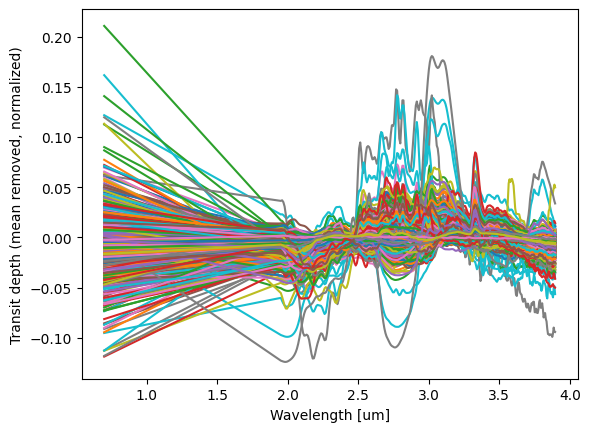

0.027111160894330914 (283,)


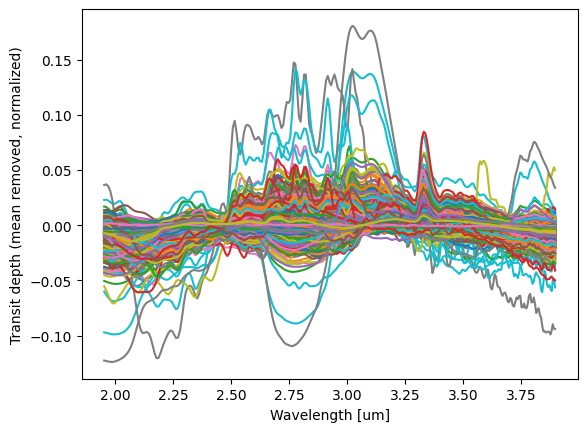

kernel_types=['matern52', 'SE'], x_forms=['id', 'gamma'], dep_sigma=[False, False]
[6.26242985e-05 8.59699469e-03 7.87144528e-02 7.86263177e-04
 9.05166754e-03] 1868668.9774737586 1868668.9774737586


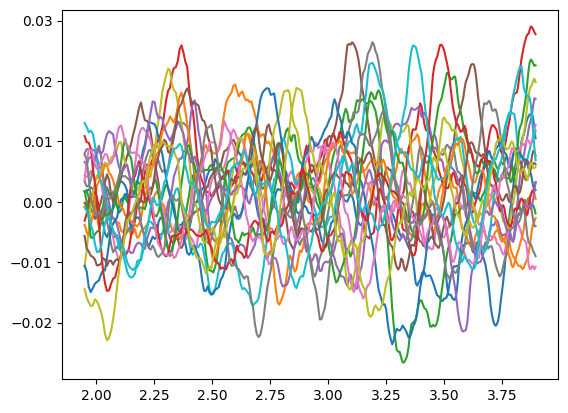

kernel_types=['matern52', 'SE'], x_forms=['id', 'gamma'], dep_sigma=[False, False]
[1.24250759e-06 1.08357223e-02 2.29014823e-01 2.83699658e+00
 1.90879866e-03 2.85733773e-01] 2153125.230207623 2153125.230207623


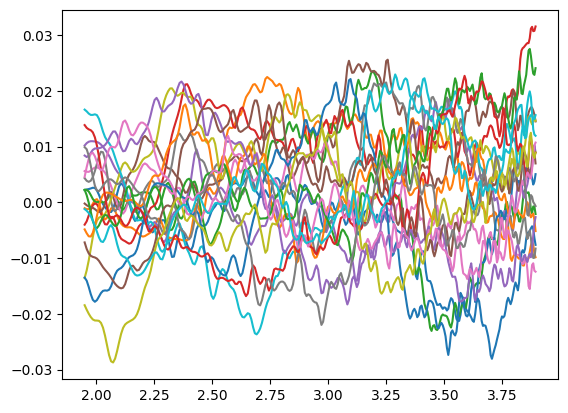

0.010000000000000002


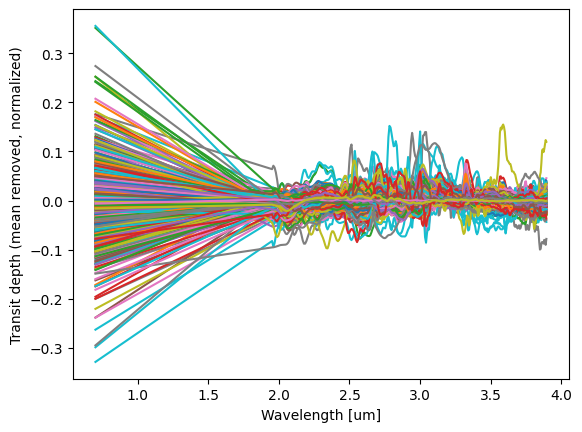

0.06016701166322641 (283,)


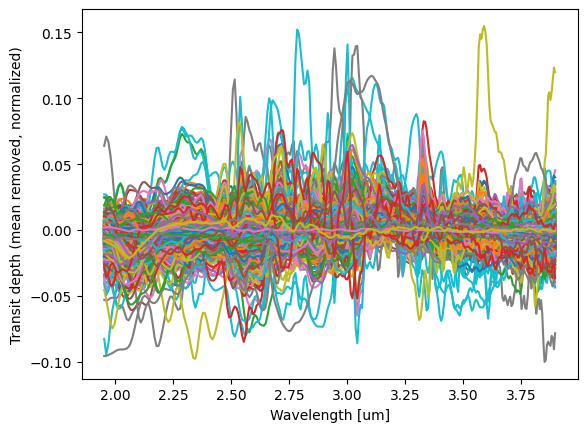

kernel_types=['matern52', 'SE'], x_forms=['id', 'gamma'], dep_sigma=[False, False]
[0.00014651 0.00873148 0.05184007 0.00186668 0.00877839] 1611261.0074876784 1611261.0074876784


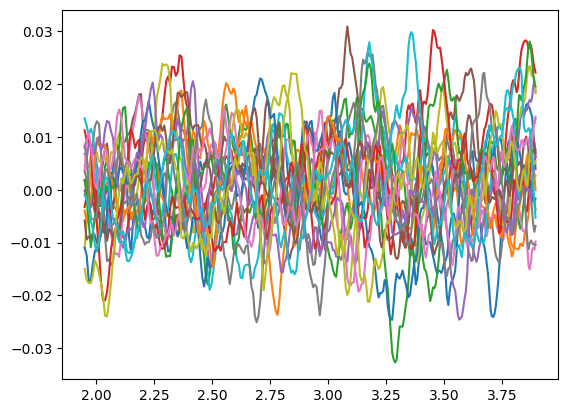

kernel_types=['matern52', 'SE'], x_forms=['id', 'gamma'], dep_sigma=[False, False]
[5.00947947e-06 9.84186749e-03 1.80540165e-01 2.81971266e+00
 4.24854071e-03 2.71009748e-01] 1885961.9141080976 1885961.9141080976


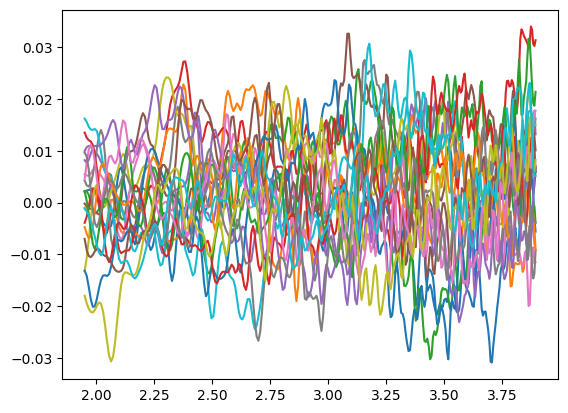

In [88]:
import gp
import importlib
importlib.reload(gp)
import cupy as cp
import scipy as sp
import copy

results = []
for use_rescaled in [False,True]:
    if use_rescaled:
        this_data = data_rescaled
    else:
        this_data = data
    data_norm = cp.array ((this_data-np.mean(this_data,0)))
    rms1 = kgs.rms(data_norm)
    data_norm  = data_norm/(np.std(data_norm,0))**0.5
    data_norm *= 0.01/kgs.rms(data_norm)
    print(kgs.rms(data_norm))
    #/((np.std(this_data-np.mean(this_data,0),0)/np.std(data[1:,:])))**1)
    #print(np.std(data_norm))
    #raise 'stop'
    plt.figure()
    plt.plot(wavelengths, data_norm.get());
    plt.xlabel('Wavelength [um]')
    plt.ylabel('Transit depth (mean removed, normalized)')
    plt.pause(0.001)
    # plt.figure()
    # plt.plot(1/wavelengths[1:], data_norm.get());
    # plt.xlabel('Wavelength [um]')
    # plt.ylabel('Transit depth (mean removed, normalized)')
    
    fgs_std = np.std(data_norm,1)[0]
    print(fgs_std, np.std(data_norm,1).shape)
    
    data_norm = data_norm[1:,:]
    
    plt.figure()
    plt.plot(wavelengths[1:], data_norm.get());
    plt.xlabel('Wavelength [um]')
    plt.ylabel('Transit depth (mean removed, normalized)')
    plt.pause(0.001)
    
    x = cp.array(wavelengths[1:])


    def K_matrix(hyperparameters):    
        gp_object.hyperparameters = hyperparameters
        return gp_object.K_matrix(x[:,None])


    def log_likelihood(hyperparameters, data):    
        K = K_matrix(hyperparameters)
        assert not(cp.any(cp.isnan(K)))
        N, M = data.shape

        # Cholesky decomposition (better numerics than slogdet/inv)
        L = cp.linalg.cholesky(K)  # K = L L^T
        assert not(cp.any(cp.isnan(L)))

        # log|K| = 2 * sum(log(diag(L)))
        logdetK = 2.0 * cp.sum(cp.log(cp.diag(L)))

        # Solve K^{-1} Y efficiently via triangular solves
        alpha = cp.linalg.solve(L, data)        # solve L α = Y
        alpha = cp.linalg.solve(L.T, alpha)     # α = K^{-1} Y

        # quadratic term = sum over columns of Y^T K^{-1} Y
        quad = cp.sum(data * alpha)

        loglik = -0.5 * (M * logdetK + quad + N*M*cp.log(2.0*cp.pi))
        return loglik

    def sample_gp(hyperparameters, n_samples):
        """
        Generate n_samples from a GP prior with covariance from K_matrix(hyperparameters).

        Args:
            hyperparameters : cp.ndarray
                Hyperparameters for the kernel (as expected by K_matrix).
            n_samples : int
                Number of draws to generate.

        Returns:
            samples : cp.ndarray of shape (N, n_samples)
                Each column is a sample from N(0, K).
        """
        K = K_matrix(hyperparameters)   # (N, N)
        N = K.shape[0]

        # Cholesky decomposition
        L = cp.linalg.cholesky(K)

        # Standard normals on GPU
        Z = cp.random.default_rng(seed=48).standard_normal(size=(N, n_samples))

        # GP samples = L @ Z
        return L @ Z

    def optimize_hyperparameters(hyp0, bounds, data):
        print(f'kernel_types={kernel_types}, x_forms={x_forms}, dep_sigma={dep_sigma}')
        def cost(x):
            #print(x, np.exp(x))
            res = log_likelihood(cp.array(np.exp(x)), data).get()
            #print(x,res)
            #print(res)
            return -res
        bounds = tuple( tuple(np.log(b) for b in bb) for bb in bounds)
        #print(bounds)
        res = sp.optimize.minimize(cost, np.log(hyp0), bounds=bounds)
        res.x = np.exp(res.x)
        #res.x[-4:-1] = 0
        samples = sample_gp(res.x, 20)    
        #print('!!!')
        print(res.x, -res.fun, log_likelihood(cp.array(res.x), data).get())
        plt.figure()
        plt.plot(x.get(), samples.get())
        plt.pause(0.001)
        return res.x

    gp_object = gp.CustomKernel()

    for kernel1 in ['matern52']:
        for kernel2 in ['SE']:
            gp_object.kernel_types = [kernel1, kernel2]
            gp_object.x_forms = ['id', 'id']
            hyp0 = [0.00017792, 0.0091591,  0.5, 0.00185574, 0.05]
            bounds = [(0.0000001,1.), (0.000001,1.), (0.005,5), (0.000001,1.), (0.005,5)]
            hyp0 = optimize_hyperparameters(hyp0, bounds, data_norm)    
            hyp0=np.insert(hyp0, 3, 1.)
            bounds.insert(3, (0.3,3))
            gp_object.x_forms = ['id', 'gamma']
            hyp0 = optimize_hyperparameters(hyp0, bounds, data_norm)    

    hyp0[1]/=100
    hyp0[4]/=100
    fgs_std/=100
    gp_object.hyperparameters = hyp0
    
    results.append( (fgs_std, gp_object) )

kgs.dill_save(kgs.code_dir + 'transit_depth_new.pickle', results)

0.00011447417037553493


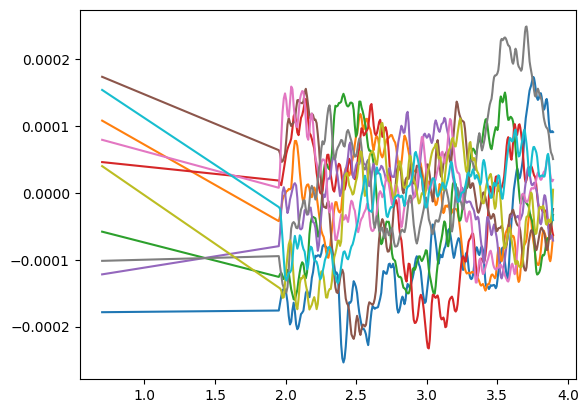

0.0006016701166322641


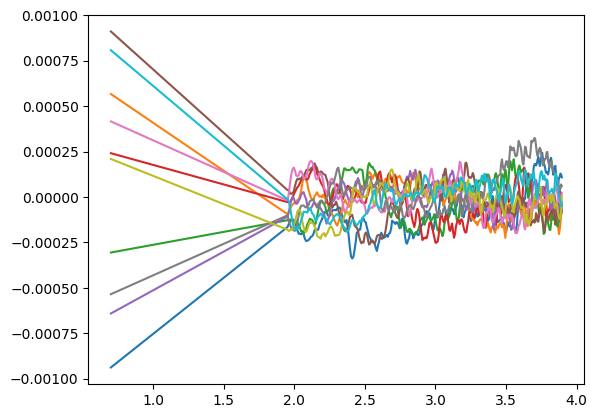

0.0002711116089433091


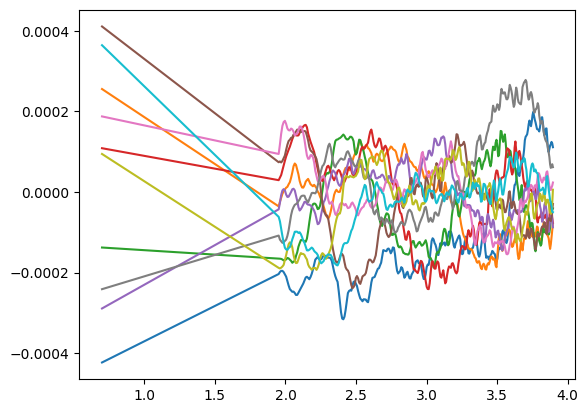

In [122]:
for ii in range(3):
    import ariel_gp
    importlib.reload(ariel_gp)
    kgs.debugging_mode = 1
    model = ariel_gp.PredictionModel()
    model.run_in_parallel = False
    model.model_options.n_iter=0
    model.model_options.use_training_labels = False
    
    if ii==0:
        model.model_options.use_old_transit_depth_prior = True
    elif ii==1:
        model.model_options.use_old_transit_depth_prior = False
        model.model_options.transit_depth_alpha = 0.
    else:
        model.model_options.use_old_transit_depth_prior = False
        model.model_options.transit_depth_alpha = 1.
    model.train(train_data)
    model.infer(train_data[0:1]);
    print('FGS sigma: ', model.results['model_mean'].m['signal'].m['main'].m['transit'].depth_model.m['variation'].m['non_pca'].m['FGS'].model.sigma)
    obs = copy.deepcopy(model.results['model_mean'].m['signal'].m['main'].m['transit'].obs_wavelength)
    model_samples = gp.sample_from_prior(model.results['model_mean'].m['signal'].m['main'].m['transit'].depth_model.m['variation'].m['non_pca'], obs, n_samples=10)
    obs.labels = model_samples.get_prediction(obs)
    #obs = copy.deepcopy(model.results['obs'])
    #gp.sample_from_prior(model.results['model_mean'], obs, n_samples=10)
    plt.figure()
    plt.plot(obs.df['wavelength'], obs.labels)
    plt.pause(0.001)